## 1. Instalacja i import bibliotek

In [12]:
!pip install datasets kagglehub pandas numpy matplotlib seaborn

Defaulting to user installation because normal site-packages is not writeable


In [13]:
from datasets import load_dataset
import kagglehub
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import os

print("✅ Biblioteki załadowane!")

✅ Biblioteki załadowane!


## 2. Pobranie danych

In [14]:
try:
    print("📥 Pobieranie AffectNet...")
    affectnet_path = kagglehub.dataset_download("mstjebashazida/affectnet")
    
    if not os.path.exists(affectnet_path):
        raise FileNotFoundError(f"AffectNet nie został pobrany poprawnie: {affectnet_path}")
    
    print(f"✅ AffectNet: {affectnet_path}")
    
except Exception as e:
    print(f"❌ BŁĄD przy pobieraniu AffectNet: {e}")
    raise

try:
    print("\n📥 Pobieranie Emotion Dataset...")
    emotion_dataset = load_dataset("dair-ai/emotion")
    
    # Walidacja
    if not emotion_dataset or 'train' not in emotion_dataset:
        raise ValueError("Emotion Dataset nie zawiera wymaganych splits (train/validation/test)")
    
    print("✅ Emotion Dataset pobrany!")
    print(f"   - Train: {len(emotion_dataset['train'])} przykładów")
    print(f"   - Validation: {len(emotion_dataset['validation'])} przykładów")
    print(f"   - Test: {len(emotion_dataset['test'])} przykładów")
    
except Exception as e:
    print(f"❌ BŁĄD przy pobieraniu Emotion Dataset: {e}")
    raise

📥 Pobieranie AffectNet...
✅ AffectNet: C:\Users\kubal\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1

📥 Pobieranie Emotion Dataset...
✅ AffectNet: C:\Users\kubal\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1

📥 Pobieranie Emotion Dataset...
✅ Emotion Dataset pobrany!
   - Train: 16000 przykładów
   - Validation: 2000 przykładów
   - Test: 2000 przykładów
✅ Emotion Dataset pobrany!
   - Train: 16000 przykładów
   - Validation: 2000 przykładów
   - Test: 2000 przykładów


## 3. Mapowanie emocji

Definiujemy wspólne kategorie dla obu zbiorów.

**Dla tekstów:**
- Sadness (0) → Smutek
- Joy (1) → Szczęście
- Love (2) → Szczęście
- Anger (3) → Złość
- Fear (4) → Strach
- Surprise (5) → Zaskoczenie

**Dla obrazów:**
- happy → Szczęście
- sad → Smutek
- anger → Złość
- fear → Strach
- surprise → Zaskoczenie

In [15]:
text_emotion_map = {
    0: 'Smutek',
    1: 'Szczęście',
    2: 'Szczęście',
    3: 'Złość',
    4: 'Strach',
    5: 'Zaskoczenie'
}

image_emotion_map = {
    'happy': 'Szczęście',
    'sad': 'Smutek',
    'anger': 'Złość',
    'fear': 'Strach',
    'surprise': 'Zaskoczenie'
}

emotion_classes = ['Szczęście', 'Smutek', 'Złość', 'Strach', 'Zaskoczenie']

print(f"Wspólne emocje: {emotion_classes}")

Wspólne emocje: ['Szczęście', 'Smutek', 'Złość', 'Strach', 'Zaskoczenie']


---
# PREPROCESSING DANYCH TEKSTOWYCH

## 4. Przygotowanie danych tekstowych

Funkcja przygotowuje DataFrame z danymi tekstowymi.

**Proces:**
1. Walidacja split (train/validation/test)
2. Mapowanie etykiet liczbowych na nazwy emocji
3. Obsługa nieznanych etykiet z ostrzeżeniem
4. Sprawdzenie zgodności liczby tekstów i etykiet
5. Usunięcie pustych wierszy

In [16]:
def prepare_text_df(dataset, split='train'):
    """
    Przygotowuje DataFrame z danymi tekstowymi.
    Zabezpieczenia: walidacja danych, obsługa błędów mapowania.
    """
    try:
        if split not in dataset:
            raise ValueError(f"Split '{split}' nie istnieje w datasecie")
        
        texts = dataset[split]['text']
        raw_labels = dataset[split]['label']
        
        labels = []
        for label in raw_labels:
            if label not in text_emotion_map:
                print(f"⚠️ UWAGA: Nieznana etykieta {label}, pomijam")
                continue
            labels.append(text_emotion_map[label])
        
        if len(texts) != len(raw_labels):
            raise ValueError(f"Niezgodność: {len(texts)} tekstów vs {len(raw_labels)} etykiet")
        
        df = pd.DataFrame({
            'text': texts,
            'emotion': labels
        })
        
        df = df.dropna()
        
        return df
        
    except Exception as e:
        print(f"❌ BŁĄD w prepare_text_df({split}): {e}")
        raise

try:
    train_text_df = prepare_text_df(emotion_dataset, 'train')
    val_text_df = prepare_text_df(emotion_dataset, 'validation')
    test_text_df = prepare_text_df(emotion_dataset, 'test')
    
    print("✅ DataFrames utworzone pomyślnie")
    print(f"\n📊 Statystyki:")
    print(f"Train:      {len(train_text_df):>6} przykładów")
    print(f"Validation: {len(val_text_df):>6} przykładów")
    print(f"Test:       {len(test_text_df):>6} przykładów")
    
    print(f"\n📈 Rozkład emocji (train):")
    for emotion in emotion_classes:
        count = len(train_text_df[train_text_df['emotion'] == emotion])
        print(f"  {emotion:<15} {count:>5} przykładów")
    
except Exception as e:
    print(f"❌ BŁĄD przy tworzeniu DataFrames: {e}")
    raise

✅ DataFrames utworzone pomyślnie

📊 Statystyki:
Train:       16000 przykładów
Validation:   2000 przykładów
Test:         2000 przykładów

📈 Rozkład emocji (train):
  Szczęście        6666 przykładów
  Smutek           4666 przykładów
  Złość            2159 przykładów
  Strach           1937 przykładów
  Zaskoczenie       572 przykładów


## 5. Zapisanie danych tekstowych

Zapisujemy przetworzone dane do plików CSV z pełną walidacją.

**Zabezpieczenia:**
- Utworzenie folderu processed_data/
- Sprawdzenie czy folder został utworzony
- Walidacja każdego zapisanego pliku (istnienie, rozmiar)
- Wyświetlenie rozmiaru każdego pliku w KB

In [17]:
try:
    data_dir = Path('processed_data')
    data_dir.mkdir(exist_ok=True)
    
    if not data_dir.exists():
        raise FileNotFoundError(f"Nie udało się utworzyć folderu: {data_dir}")
    
    files_saved = []
    
    train_text_df.to_csv(data_dir / 'train_text.csv', index=False)
    files_saved.append('train_text.csv')
    
    val_text_df.to_csv(data_dir / 'val_text.csv', index=False)
    files_saved.append('val_text.csv')
    
    test_text_df.to_csv(data_dir / 'test_text.csv', index=False)
    files_saved.append('test_text.csv')
    
    for filename in files_saved:
        filepath = data_dir / filename
        if not filepath.exists():
            raise FileNotFoundError(f"Plik nie został zapisany: {filepath}")
        
        if filepath.stat().st_size == 0:
            raise ValueError(f"Plik jest pusty: {filepath}")
    
    print("✅ Dane tekstowe zapisane w 'processed_data/'")
    for filename in files_saved:
        filepath = data_dir / filename
        size_kb = filepath.stat().st_size / 1024
        print(f"   - {filename} ({size_kb:.1f} KB)")
    
except Exception as e:
    print(f"❌ BŁĄD przy zapisywaniu danych tekstowych: {e}")
    raise

✅ Dane tekstowe zapisane w 'processed_data/'
   - train_text.csv (1693.4 KB)
   - val_text.csv (209.1 KB)
   - test_text.csv (211.3 KB)


---
# PREPROCESSING DANYCH OBRAZOWYCH

## 6. Skanowanie folderów z obrazami

Funkcja przeszukuje **wszystkie** foldery w AffectNet rekurencyjnie.

**Funkcjonalności:**
- Case-insensitive matching nazw folderów (happy, Happy, HAPPY)
- Obsługa wielokrotnych rozszerzeń (jpg, jpeg, png)
- Rekurencyjne przeszukiwanie (train/, validation/, test/)
- Walidacja ścieżki bazowej i każdego pliku
- Sprawdzanie czy znaleziono wszystkie emocje
- Szczegółowe logowanie

In [23]:
def scan_images(base_path, emotion_map):
    """
    Skanuje wszystkie obrazy w folderach emocji (case-insensitive).
    Zwraca ścieżki WZGLĘDNE (od base_path) dla uniwersalności.
    Zabezpieczenia: walidacja ścieżki, matching nazw, walidacja plików.
    """
    try:
        if not os.path.exists(base_path):
            raise FileNotFoundError(f"Ścieżka nie istnieje: {base_path}")
        
        if not os.path.isdir(base_path):
            raise NotADirectoryError(f"To nie jest folder: {base_path}")
        
        base_path = os.path.abspath(base_path)
        image_list = []
        folders_found = set()
        
        for root, dirs, files in os.walk(base_path):
            folder_name = os.path.basename(root).lower()
            
            emotion_label = None
            for emotion_key, emotion_value in emotion_map.items():
                if folder_name == emotion_key.lower():
                    emotion_label = emotion_value
                    folders_found.add(emotion_key)
                    break
            
            if emotion_label:
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(root, file)
                        
                        if os.path.exists(img_path) and os.path.getsize(img_path) > 0:
                            relative_path = os.path.relpath(img_path, base_path)
                            image_list.append({
                                'path': relative_path,
                                'emotion': emotion_label
                            })
        
        if not folders_found:
            print(f"⚠️ UWAGA: Nie znaleziono żadnych folderów z emocjami!")
            print(f"   Szukane: {list(emotion_map.keys())}")
            print(f"   W lokalizacji: {base_path}")
        
        df = pd.DataFrame(image_list)
        
        if len(df) == 0:
            print(f"⚠️ UWAGA: Nie znaleziono żadnych obrazów!")
            return df
        
        print("\n📊 Znalezione obrazy według emocji:")
        for emotion in emotion_map.values():
            count = len(df[df['emotion'] == emotion])
            if count > 0:
                print(f"  {emotion:<15} {count:>6} obrazów ✅")
            else:
                print(f"  {emotion:<15} {count:>6} obrazów ⚠️")
        
        missing_emotions = set(emotion_map.values()) - set(df['emotion'].unique())
        if missing_emotions:
            print(f"\n⚠️ UWAGA: Brakujące emocje: {missing_emotions}")
        
        return df
        
    except Exception as e:
        print(f"❌ BŁĄD w scan_images: {e}")
        raise

try:
    print("🔍 Skanowanie obrazów AffectNet...")
    print(f"📂 Lokalizacja: {affectnet_path}")
    print(f"🎯 Szukam folderów: {list(image_emotion_map.keys())}\n")
    
    image_df = scan_images(affectnet_path, image_emotion_map)
    
    if len(image_df) == 0:
        raise ValueError("Nie znaleziono żadnych obrazów! Sprawdź strukturę folderów AffectNet.")
    
    print(f"\n✅ ŁĄCZNIE znaleziono: {len(image_df)} obrazów")
    
except Exception as e:
    print(f"❌ BŁĄD przy skanowaniu obrazów: {e}")
    raise

🔍 Skanowanie obrazów AffectNet...
📂 Lokalizacja: C:\Users\kubal\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1
🎯 Szukam folderów: ['happy', 'sad', 'anger', 'fear', 'surprise']


📊 Znalezione obrazy według emocji:
  Szczęście         5044 obrazów ✅
  Smutek            4675 obrazów ✅
  Złość             3218 obrazów ✅
  Strach            3176 obrazów ✅
  Zaskoczenie       4039 obrazów ✅

✅ ŁĄCZNIE znaleziono: 20152 obrazów

📊 Znalezione obrazy według emocji:
  Szczęście         5044 obrazów ✅
  Smutek            4675 obrazów ✅
  Złość             3218 obrazów ✅
  Strach            3176 obrazów ✅
  Zaskoczenie       4039 obrazów ✅

✅ ŁĄCZNIE znaleziono: 20152 obrazów


## 7. Podział danych obrazowych

Dzielimy dane na train/val/test (70/15/15) ze stratyfikacją.

**Proces:**
1. Walidacja danych przed podziałem
2. Sprawdzenie liczebności każdej klasy
3. Ostrzeżenie jeśli < 3 przykłady (problemy z stratyfikacją)
4. Podział z zachowaniem proporcji emocji
5. Walidacja po podziale (suma == total)

In [24]:
from sklearn.model_selection import train_test_split

try:
    if len(image_df) == 0:
        raise ValueError("Brak danych do podziału!")
    
    unique_emotions = image_df['emotion'].unique()
    print(f"📋 Emocje w zbiorze: {list(unique_emotions)}")
    
    emotion_counts = image_df['emotion'].value_counts()
    print(f"\n📊 Rozkład przed podziałem:")
    for emotion, count in emotion_counts.items():
        print(f"  {emotion:<15} {count:>6} obrazów")
    
    min_samples = emotion_counts.min()
    if min_samples < 3:
        print(f"\n⚠️ UWAGA: Niektóre klasy mają mniej niż 3 przykłady!")
        print(f"   Stratyfikacja może nie działać poprawnie.")
    
    train_img, temp_img = train_test_split(
        image_df, 
        test_size=0.3, 
        random_state=42, 
        stratify=image_df['emotion']
    )
    
    val_img, test_img = train_test_split(
        temp_img, 
        test_size=0.5, 
        random_state=42, 
        stratify=temp_img['emotion']
    )
    
    total = len(train_img) + len(val_img) + len(test_img)
    if total != len(image_df):
        raise ValueError(f"Błąd podziału: {total} != {len(image_df)}")
    
    print(f"\n✅ Podział danych obrazowych:")
    print(f"Train:      {len(train_img):>6} obrazów ({len(train_img)/len(image_df)*100:.1f}%)")
    print(f"Validation: {len(val_img):>6} obrazów ({len(val_img)/len(image_df)*100:.1f}%)")
    print(f"Test:       {len(test_img):>6} obrazów ({len(test_img)/len(image_df)*100:.1f}%)")
    print(f"SUMA:       {total:>6} obrazów")
    
    print(f"\n📈 Rozkład w zbiorze treningowym:")
    train_counts = train_img['emotion'].value_counts()
    for emotion in emotion_classes:
        if emotion in train_counts:
            count = train_counts[emotion]
            percentage = (count / len(train_img)) * 100
            print(f"  {emotion:<15} {count:>5} ({percentage:>5.1f}%)")
    
except Exception as e:
    print(f"❌ BŁĄD przy podziale danych obrazowych: {e}")
    raise

📋 Emocje w zbiorze: ['Złość', 'Strach', 'Szczęście', 'Smutek', 'Zaskoczenie']

📊 Rozkład przed podziałem:
  Szczęście         5044 obrazów
  Smutek            4675 obrazów
  Zaskoczenie       4039 obrazów
  Złość             3218 obrazów
  Strach            3176 obrazów

✅ Podział danych obrazowych:
Train:       14106 obrazów (70.0%)
Validation:   3023 obrazów (15.0%)
Test:         3023 obrazów (15.0%)
SUMA:        20152 obrazów

📈 Rozkład w zbiorze treningowym:
  Szczęście        3531 ( 25.0%)
  Smutek           3272 ( 23.2%)
  Złość            2253 ( 16.0%)
  Strach           2223 ( 15.8%)
  Zaskoczenie      2827 ( 20.0%)


## 8. Zapisanie danych obrazowych

Zapisujemy dane obrazowe do plików CSV z pełną walidacją.

**Zabezpieczenia:**
- Walidacja każdego zapisanego pliku
- Sprawdzenie czy można wczytać CSV
- Wyświetlenie liczby wierszy i rozmiaru

In [25]:
try:
    files_saved = []
    
    train_img.to_csv(data_dir / 'train_images.csv', index=False)
    files_saved.append('train_images.csv')
    
    val_img.to_csv(data_dir / 'val_images.csv', index=False)
    files_saved.append('val_images.csv')
    
    test_img.to_csv(data_dir / 'test_images.csv', index=False)
    files_saved.append('test_images.csv')
    
    print("✅ Dane obrazowe zapisane w 'processed_data/'")
    for filename in files_saved:
        filepath = data_dir / filename
        
        if not filepath.exists():
            raise FileNotFoundError(f"Plik nie został zapisany: {filepath}")
        
        size_bytes = filepath.stat().st_size
        if size_bytes == 0:
            raise ValueError(f"Plik jest pusty: {filepath}")
        
        test_df = pd.read_csv(filepath)
        if len(test_df) == 0:
            raise ValueError(f"Plik zawiera 0 wierszy: {filepath}")
        
        size_kb = size_bytes / 1024
        print(f"   - {filename:<20} {size_kb:>8.1f} KB ({len(test_df):>6} wierszy) ✅")
    
except Exception as e:
    print(f"❌ BŁĄD przy zapisywaniu danych obrazowych: {e}")
    raise

✅ Dane obrazowe zapisane w 'processed_data/'
   - train_images.csv        690.9 KB ( 14106 wierszy) ✅
   - val_images.csv          148.1 KB (  3023 wierszy) ✅
   - test_images.csv         148.1 KB (  3023 wierszy) ✅


## 8a. Zapisanie ścieżki bazowej

Zapisujemy absolutną ścieżkę do danych AffectNet, aby inne notebooki mogły odtworzyć pełne ścieżki z względnych.

**Uzasadnienie:**
- CSV zawiera ścieżki względne (np. `Train/happy/img001.jpg`)
- Potrzebujemy base_path do odtworzenia pełnej ścieżki
- Plik `data_paths.json` przechowuje tę informację

In [26]:
import json

try:
    data_paths = {
        'affectnet_base_path': os.path.abspath(affectnet_path),
        'note': 'Ścieżki w CSV są względne. Użyj affectnet_base_path + relative_path aby uzyskać pełną ścieżkę.'
    }
    
    config_path = data_dir / 'data_paths.json'
    with open(config_path, 'w', encoding='utf-8') as f:
        json.dump(data_paths, f, indent=2, ensure_ascii=False)
    
    print("✅ Konfiguracja ścieżek zapisana:")
    print(f"   Plik: {config_path}")
    print(f"   Base path: {data_paths['affectnet_base_path']}")
    
except Exception as e:
    print(f"❌ BŁĄD przy zapisywaniu konfiguracji: {e}")
    raise

✅ Konfiguracja ścieżek zapisana:
   Plik: processed_data\data_paths.json
   Base path: C:\Users\kubal\.cache\kagglehub\datasets\mstjebashazida\affectnet\versions\1


---
# PODSUMOWANIE

## 9. Statystyki finalne

Pełne podsumowanie preprocessing z walidacją wszystkich plików.

In [21]:
try:
    print("="*60)
    print("PODSUMOWANIE PREPROCESSINGU")
    print("="*60)
    
    required_files = [
        'train_text.csv', 'val_text.csv', 'test_text.csv',
        'train_images.csv', 'val_images.csv', 'test_images.csv'
    ]
    
    missing_files = []
    for filename in required_files:
        if not (data_dir / filename).exists():
            missing_files.append(filename)
    
    if missing_files:
        raise FileNotFoundError(f"Brakujące pliki: {missing_files}")
    
    print("\n📝 DANE TEKSTOWE:")
    print(f"  Train:      {len(train_text_df):>6} przykładów")
    print(f"  Validation: {len(val_text_df):>6} przykładów")
    print(f"  Test:       {len(test_text_df):>6} przykładów")
    print(f"  SUMA:       {len(train_text_df) + len(val_text_df) + len(test_text_df):>6} przykładów")
    print(f"  Emocje:     {len(emotion_classes)} klas")
    
    print("\n🖼️  DANE OBRAZOWE:")
    print(f"  Train:      {len(train_img):>6} obrazów")
    print(f"  Validation: {len(val_img):>6} obrazów")
    print(f"  Test:       {len(test_img):>6} obrazów")
    print(f"  SUMA:       {len(train_img) + len(val_img) + len(test_img):>6} obrazów")
    print(f"  Emocje:     {len(image_emotion_map)} klas")
    
    print("\n💾 ZAPISANE PLIKI:")
    print("  processed_data/")
    total_size = 0
    for filename in required_files:
        filepath = data_dir / filename
        size_kb = filepath.stat().st_size / 1024
        total_size += size_kb
        print(f"    ├── {filename:<20} {size_kb:>8.1f} KB")
    
    print(f"\n📦 Całkowity rozmiar: {total_size/1024:.2f} MB")
    
    print("\n✅ Preprocessing zakończony pomyślnie!")
    print("   Wszystkie pliki zapisane i zwalidowane.")
    print("   Dane gotowe do trenowania modeli.")
    
except Exception as e:
    print(f"\n❌ BŁĄD w podsumowaniu: {e}")
    print("⚠️  Preprocessing może być niekompletny!")
    raise

PODSUMOWANIE PREPROCESSINGU

📝 DANE TEKSTOWE:
  Train:       16000 przykładów
  Validation:   2000 przykładów
  Test:         2000 przykładów
  SUMA:        20000 przykładów
  Emocje:     5 klas

🖼️  DANE OBRAZOWE:
  Train:       14106 obrazów
  Validation:   3023 obrazów
  Test:         3023 obrazów
  SUMA:        20152 obrazów
  Emocje:     5 klas

💾 ZAPISANE PLIKI:
  processed_data/
    ├── train_text.csv         1693.4 KB
    ├── val_text.csv            209.1 KB
    ├── test_text.csv           211.3 KB
    ├── train_images.csv       1751.6 KB
    ├── val_images.csv          375.4 KB
    ├── test_images.csv         375.5 KB

📦 Całkowity rozmiar: 4.51 MB

✅ Preprocessing zakończony pomyślnie!
   Wszystkie pliki zapisane i zwalidowane.
   Dane gotowe do trenowania modeli.

📝 DANE TEKSTOWE:
  Train:       16000 przykładów
  Validation:   2000 przykładów
  Test:         2000 przykładów
  SUMA:        20000 przykładów
  Emocje:     5 klas

🖼️  DANE OBRAZOWE:
  Train:       14106 obrazów


## 10. Porównanie zbiorów

Wizualizacja rozkładu emocji w zbiorach treningowych.

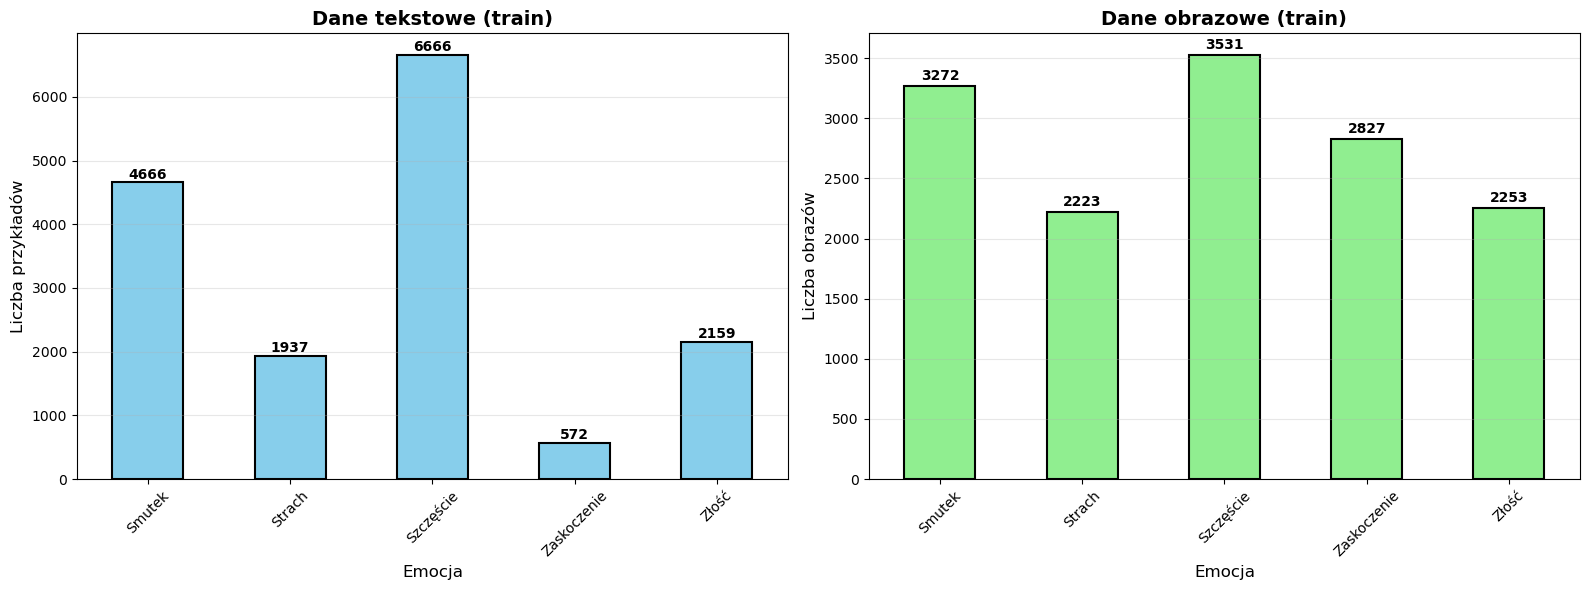

✅ Wykresy wygenerowane pomyślnie


In [22]:
try:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    text_counts = train_text_df['emotion'].value_counts().sort_index()
    text_counts.plot(kind='bar', ax=ax1, color='skyblue', edgecolor='black', linewidth=1.5)
    ax1.set_title('Dane tekstowe (train)', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Emocja', fontsize=12)
    ax1.set_ylabel('Liczba przykładów', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(text_counts):
        ax1.text(i, v + 50, str(v), ha='center', fontweight='bold')
    
    img_counts = train_img['emotion'].value_counts().sort_index()
    img_counts.plot(kind='bar', ax=ax2, color='lightgreen', edgecolor='black', linewidth=1.5)
    ax2.set_title('Dane obrazowe (train)', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Emocja', fontsize=12)
    ax2.set_ylabel('Liczba obrazów', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    
    for i, v in enumerate(img_counts):
        ax2.text(i, v + 50, str(v), ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✅ Wykresy wygenerowane pomyślnie")
    
except Exception as e:
    print(f"❌ BŁĄD przy tworzeniu wykresów: {e}")
    print("⚠️  Dane są zapisane, ale wizualizacja się nie powiodła")